# <center>An Elementary Particle Collider Signal Filter</center>
#### <center> Developed by Luke Surber, SurberL9@uw.edu </center>

### README: 
### This notebook is designed to model the luminosity and particle distributions of particles traveling in a collider, the specific aim is to filter any noise from the signal using Python code. In High Energy Physics (HEP), very often the problem of seperating signal from backgroundnoise arises; some scenario include resonant peaks from particle decays (focus of this nb), physics object reconstruction/identification (id est pions, photons, electrons, b(t)-jets...), nuclear interactions with detector materials, photon conversions with detector material, all of these phenomena would be combined with noise.
### The example scenario used in this notebook is the Higgs boson decay, it's resonant peak occurs at ~125 GeV with a STD of 20 GeV (Forgot where I got this from...); this signal is 'dirtied' in two ways, first there's an additional background signal (calling it background noise) that has a gaussian distribution (sigma=30GeV,mu=30GeV), and second there's an overall random noise that 'dirties' the signal further. All of these sources of noise need to be filtered out, this is the goal of this nb.

#!pip install --upgrade jax jaxlib #This is for systems that haven't installed JAX, uncomment if this is the case.

In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
key = random.PRNGKey(0)
import random as rand
import math, jax
from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np
from numpy import inf
plt.style.use('dark_background');

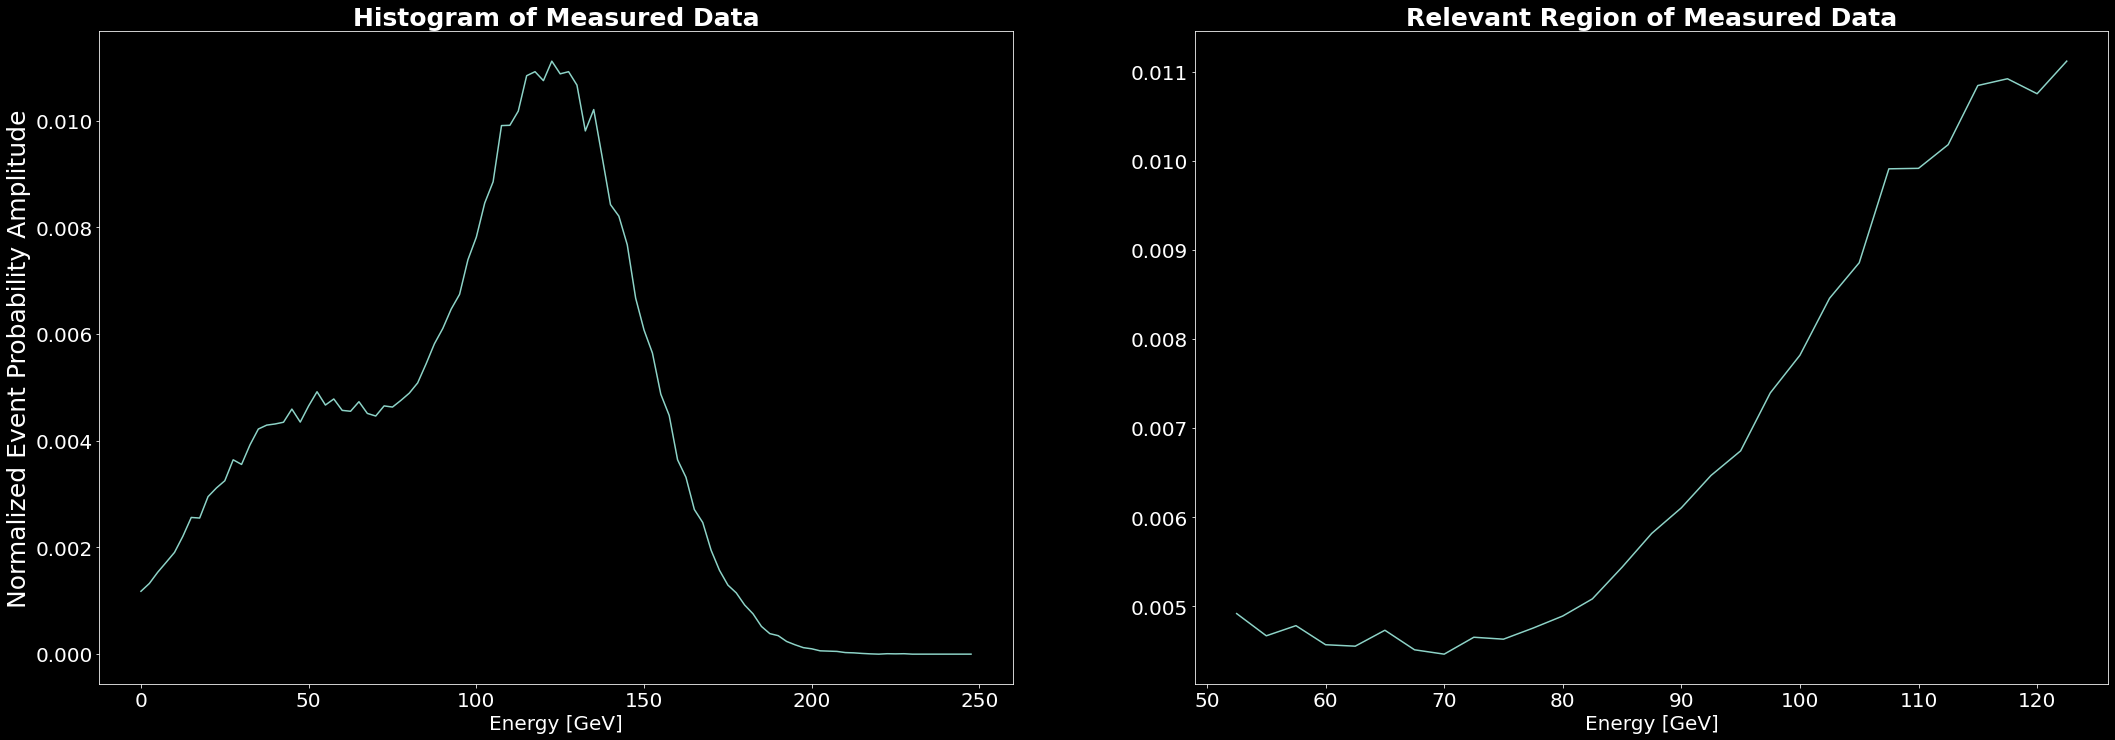

In [2]:
size = 100000 #Arbitrarily chosen 100,000 Signal Events
background_events = int(size/2)
signal_mean, noise_mean = 125, 50
signal_std, noise_std = 25, 30
mean = jnp.array([signal_mean,noise_mean]).block_until_ready()#block_until_ready helps speed up #Mean Matrix
cov = jnp.array([[signal_std**2,0],[0,noise_std**2]]).block_until_ready() #Covariance Matrix
x1, x2 = random.multivariate_normal(key, mean, cov, (size,)).T.block_until_ready()
sig, nos = x1, x2
dat = jnp.concatenate((sig,nos[:background_events])) #This array contains the dirty signal that's contaminated with background noise.
hist = jnp.histogram(dat, bins=100, range=(0,250), density=True) #This converts the data set array into an array that describes the resulting histogram, note that precision is diminished by the bin count.
yval = [] #The empty array that'll be filled with yvalues of the points between the two peaks
xval = [] #The empty array that'll be filled with xvalues of the points between the two peaks
for i in range(len(hist[0])):
    if noise_mean < hist[1][i+1].item() < signal_mean:
        xval.append(hist[1][i+1].item()) #.item() takes the value out of the DeviceArray
        yval.append(hist[0][i+1].item())
    else:
        pass
fig, axs = plt.subplots(1,2, figsize=(36,12))
axs[0].plot(hist[1][:-1],hist[0])
axs[1].plot(xval,yval)
axs[0].set_ylabel("Normalized Event Probability Amplitude", size=25) #Sum of probabilties is unity.
axs[0].set_xlabel("Energy [GeV]", size=20)
axs[0].tick_params(labelsize=20)
axs[1].set_xlabel("Energy [GeV]", size=20)
axs[1].tick_params(labelsize=20)
axs[0].set_title("Histogram of Measured Data", fontweight="bold", size=25)
axs[1].set_title("Relevant Region of Measured Data", fontweight="bold", size=25);

### Experimental Perspective: The dataset is the apparent sum of two gaussian distributions, one of them being the desired signal. The task of seperating the undesired part of the dataset from the signal can be solved by applying a Signal to Noise Ratio (SNR) to the data, within the SNR values will be an extrema that corresponds to the point for the optimal cut.
### After the cut is made the dataset should then be curve fitted to a guassian using an iterative gradient descent algorithm. 

In [3]:
#########################################################################################
#                            Signal to Noise Ratio                                      #
#########################################################################################
#Discrete Version
def SNRd(signal, noise): #Defining the Discrete SNR Function.
    s, n = signal[0], noise[0]
    snr = []
    for i in range(len(signal[0])):
        r = s[i+1] / n[i+1]**2
        r = jnp.nan_to_num(r, nan=0.0, posinf=0.0)
        snr.append(r.item())
    return snr
#Continous Version
def SNR(s, n): #Defining the Continuous SNR Function.
    snr, Srray, Nrray = [], [], []
    for i in range(len(s[0])):
#Below; Mathematical equivalent to a 'running' Riemann Sum or Definite Integration.
        N = 2.5 * jnp.nansum(n[0][:i+1])
        S = s[0][i+1]
        Srray.append(S)
        Nrray.append(N)
        N = np.sum(Nrray)
        r = S / N**2
#Below; Appropriately interpolates the datset with zeroes.        
        r = jnp.nan_to_num(r, nan=0.0, posinf=0.0)
        snr.append(r.item())
    return snr, Srray, Nrray
#Notes: TypeError appears when using jnp.sum here, the jnp version requires ndarray or scalar arguments.
#########################################################################################
#                             Toy Data Generation                                       #
#########################################################################################
#  Example Scenario: Higgs Boson has a 125 GeV Mass, assuming an arbitrary 20 GeV STD.  #
sig_events, nos_events, Emax = 10**5, 5*10**4, 250
sig_mean, nos_mean, sig_std, nos_std = 125, 30, 20, 30 
size, mean, cov, bins = sig_events, jnp.array([sig_mean,nos_mean]).block_until_ready(), jnp.array([[sig_std**2,0],[0,nos_std**2]]).block_until_ready(), Emax 
#Generating Two Gaussian Distributions that are used for the background noise and signal.
signal, noise = random.multivariate_normal(key, mean, cov, (size,)).T.block_until_ready()
signal, noise = signal[signal<250], noise[noise<100] #Implementing the bounds on the data.
#Combining the signal with both background nosie and random noise.
data_array = jnp.concatenate((signal,noise[:nos_events]))+np.random.normal(0,2.5,len(signal)+len(noise[:nos_events])) 
sig = jnp.histogram(signal, bins=bins, range=(0,250), density=False) 
nos = jnp.histogram(noise, bins=bins, range=(0,100), density=False)
snr_dat, s, n = SNR(sig, nos)[:125][0], SNR(sig, nos)[:125][1], SNR(sig, nos)[:125][2]
snr_domain = jnp.arange(0,125,0.5)
snrd_dat = SNRd(sig, nos)
snrd_domain = jnp.arange(len(snrd_dat))
optimal_cut = 2.5*round((snr_domain[snr_dat.index(jnp.nanmax(jnp.asarray(snr_dat)).item())].item())/2.5)
optimal_dcut = 2.5*round((snrd_domain[snrd_dat.index(jnp.nanmax(jnp.asarray(snrd_dat)).item())].item())/2.5)
#Rounding here is neccesary to get the nearest bin value
cut_data_array = data_array[data_array > optimal_cut]
data_hist = jnp.histogram(data_array, bins=bins, range=(0,250), density=False)
cut_data_hist = jnp.histogram(cut_data_array, bins=bins, range=(0,250), density=False); 
cut_data_histn = jnp.histogram(cut_data_array, bins=bins, range=(0,250), density=True);
##########################################################################################
#                                Latest Version                                          #
##########################################################################################

### The Signal-Noise Ratio is found by using a gaussian representing the signal and another for the background noise (not random noise), this in an experimental setting could be found by approximating the real dataset as a "rough" sum of two gaussians then identify which is the signal and which is the background noise (UPDATE THIS REGION). Using them the Signal-Noise Ratio can be computed.

### If a reasonable mean for background noise can be given, like 50 GeV, and if the process of interest occurs at energies around 120 GeV, then this elementary filter can succesfully automatically find the optimal cut, and return a filtered dataset.

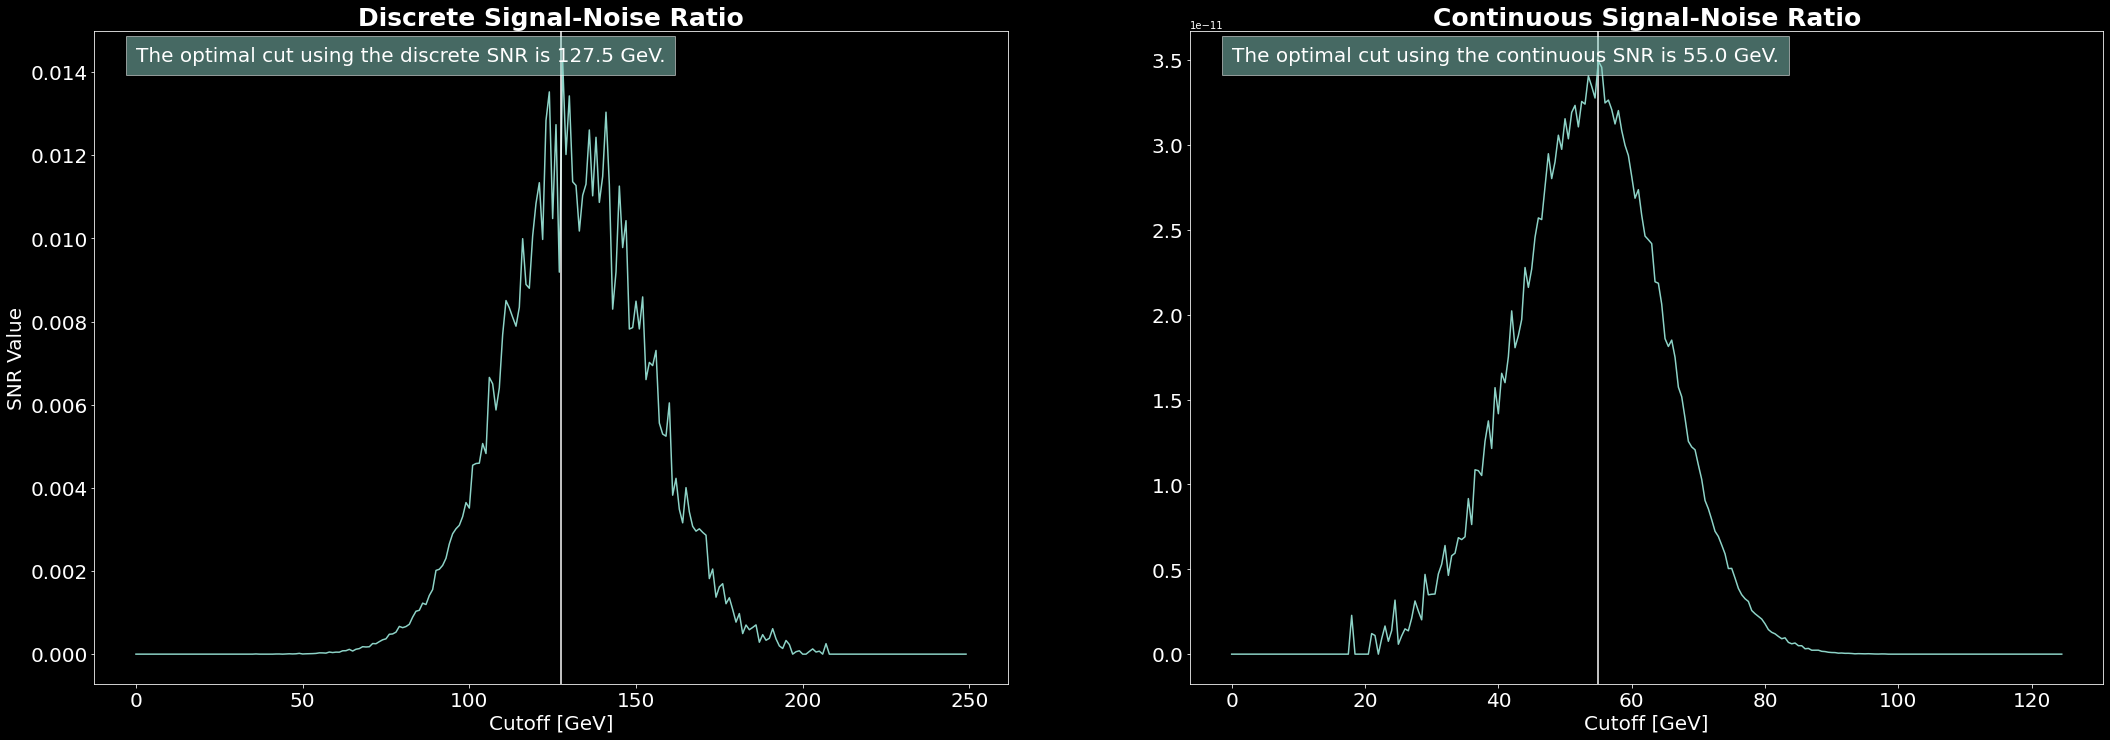

In [4]:
#plotting both methods of getting SNR
fig, axs = plt.subplots(1,2, figsize=(36,12))
axs[0].set_ylabel("SNR Value", size=20)
axs[0].set_xlabel("Cutoff [GeV]", size=20)
axs[0].tick_params(labelsize=20)
axs[0].plot(snrd_domain,snrd_dat)
axs[0].set_title("Discrete Signal-Noise Ratio", fontweight="bold", size=25)
axs[0].text(0, np.max(snrd_dat), 'The optimal cut using the discrete SNR is {} GeV.'.format(optimal_dcut),
        bbox={'alpha': 0.5, 'pad': 10}, size=20)
axs[0].axvline(optimal_dcut)
axs[1].axvline(optimal_cut)
axs[1].set_xlabel("Cutoff [GeV]", size=20)
axs[1].tick_params(labelsize=20)
axs[1].plot(snr_domain,snr_dat)
axs[1].set_title("Continuous Signal-Noise Ratio", fontweight="bold", size=25)
axs[1].text(0, np.max(snr_dat), 'The optimal cut using the continuous SNR is {} GeV.'.format(optimal_cut),
        bbox={'alpha': 0.5, 'pad': 10}, size=20);

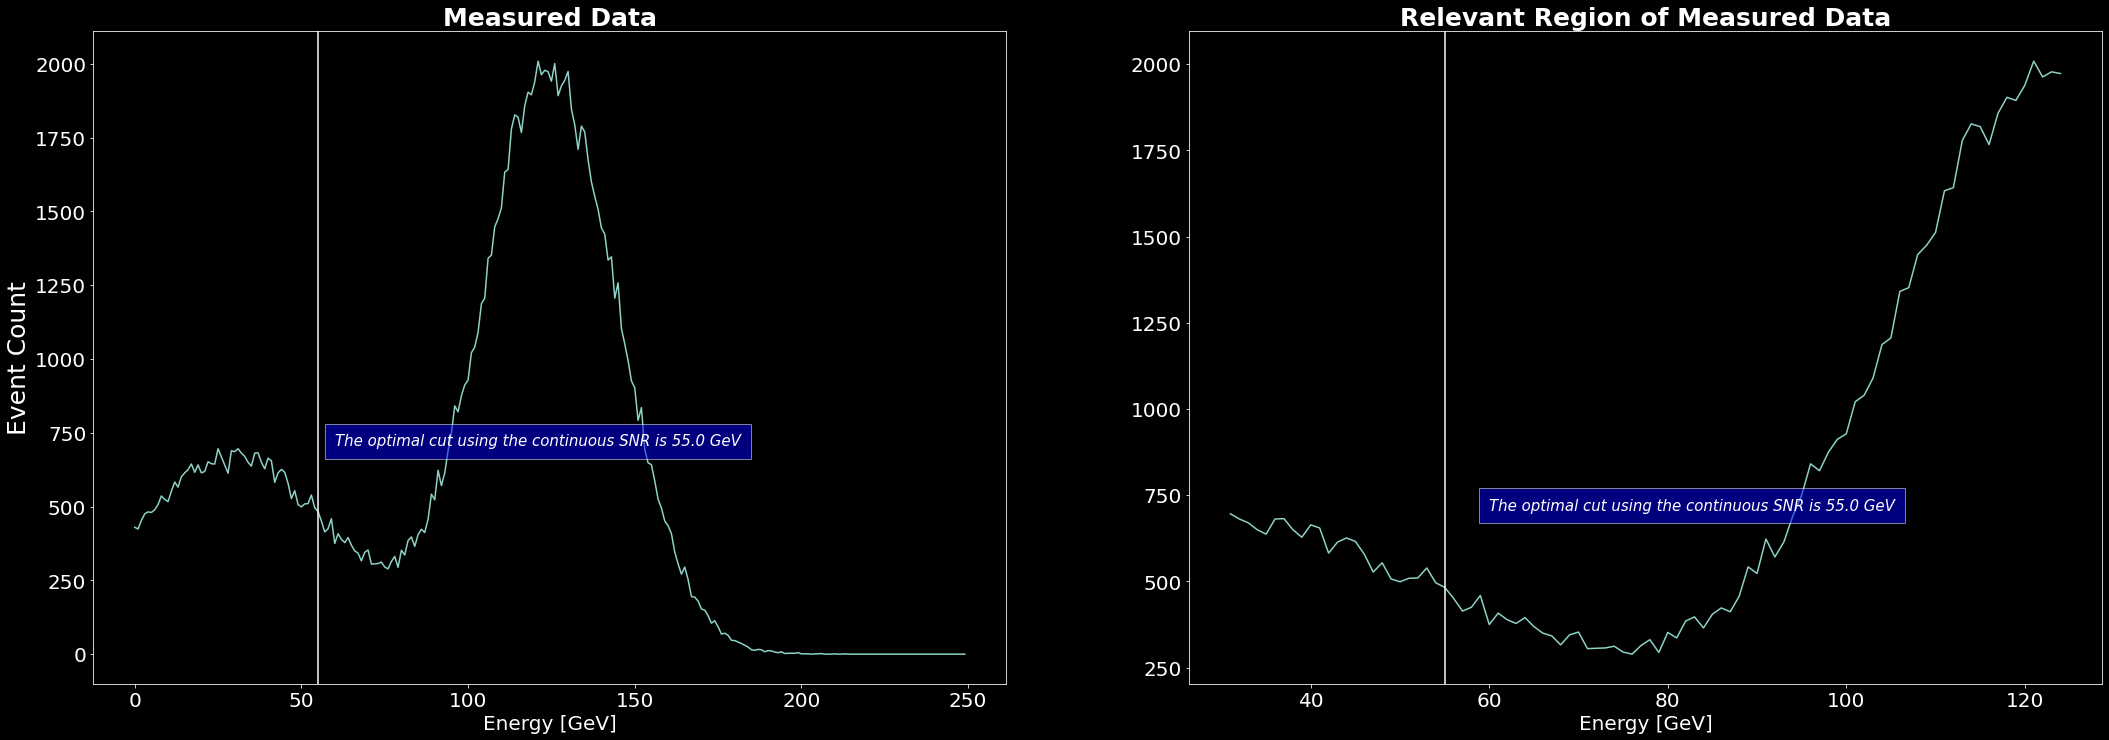

In [5]:
###################################################################################################################################
#                                                                                                               #
###################################################################################################################################
yval = [] #The empty array that'll be filled with yvalues of the points between the two peaks
xval = [] #The empty array that'll be filled with xvalues of the points between the two peaks
for i in range(len(data_hist[0])):
    if nos_mean < data_hist[1][i+1].item() < sig_mean:
        xval.append(data_hist[1][i+1].item()) #.item() takes the value out of the DeviceArray
        yval.append(data_hist[0][i+1].item())
    else:
        pass
fig, axs = plt.subplots(1,2, figsize=(36,12))
axs[0].plot(data_hist[1][:-1],data_hist[0])
axs[1].plot(xval,yval)
axs[0].set_ylabel("Event Count", size=25)
axs[0].set_xlabel("Energy [GeV]", size=20)
axs[0].tick_params(labelsize=20)
axs[1].set_xlabel("Energy [GeV]", size=20)
axs[1].tick_params(labelsize=20)
axs[0].set_title("Measured Data", fontweight="bold", size=25)
axs[1].set_title("Relevant Region of Measured Data", fontweight="bold", size=25)
axs[0].axvline(optimal_cut)
axs[1].axvline(optimal_cut)
axs[0].text(optimal_cut+5, 2*yval[xval.index(70)], 'The optimal cut using the continuous SNR is {} GeV'.format(optimal_cut), style='italic',
        bbox={'facecolor': 'blue', 'alpha': 0.5, 'pad': 10}, size=15)
axs[1].text(optimal_cut+5, 2*yval[xval.index(70)], 'The optimal cut using the continuous SNR is {} GeV'.format(optimal_cut), style='italic',
        bbox={'facecolor': 'blue', 'alpha': 0.5, 'pad': 10}, size=15);

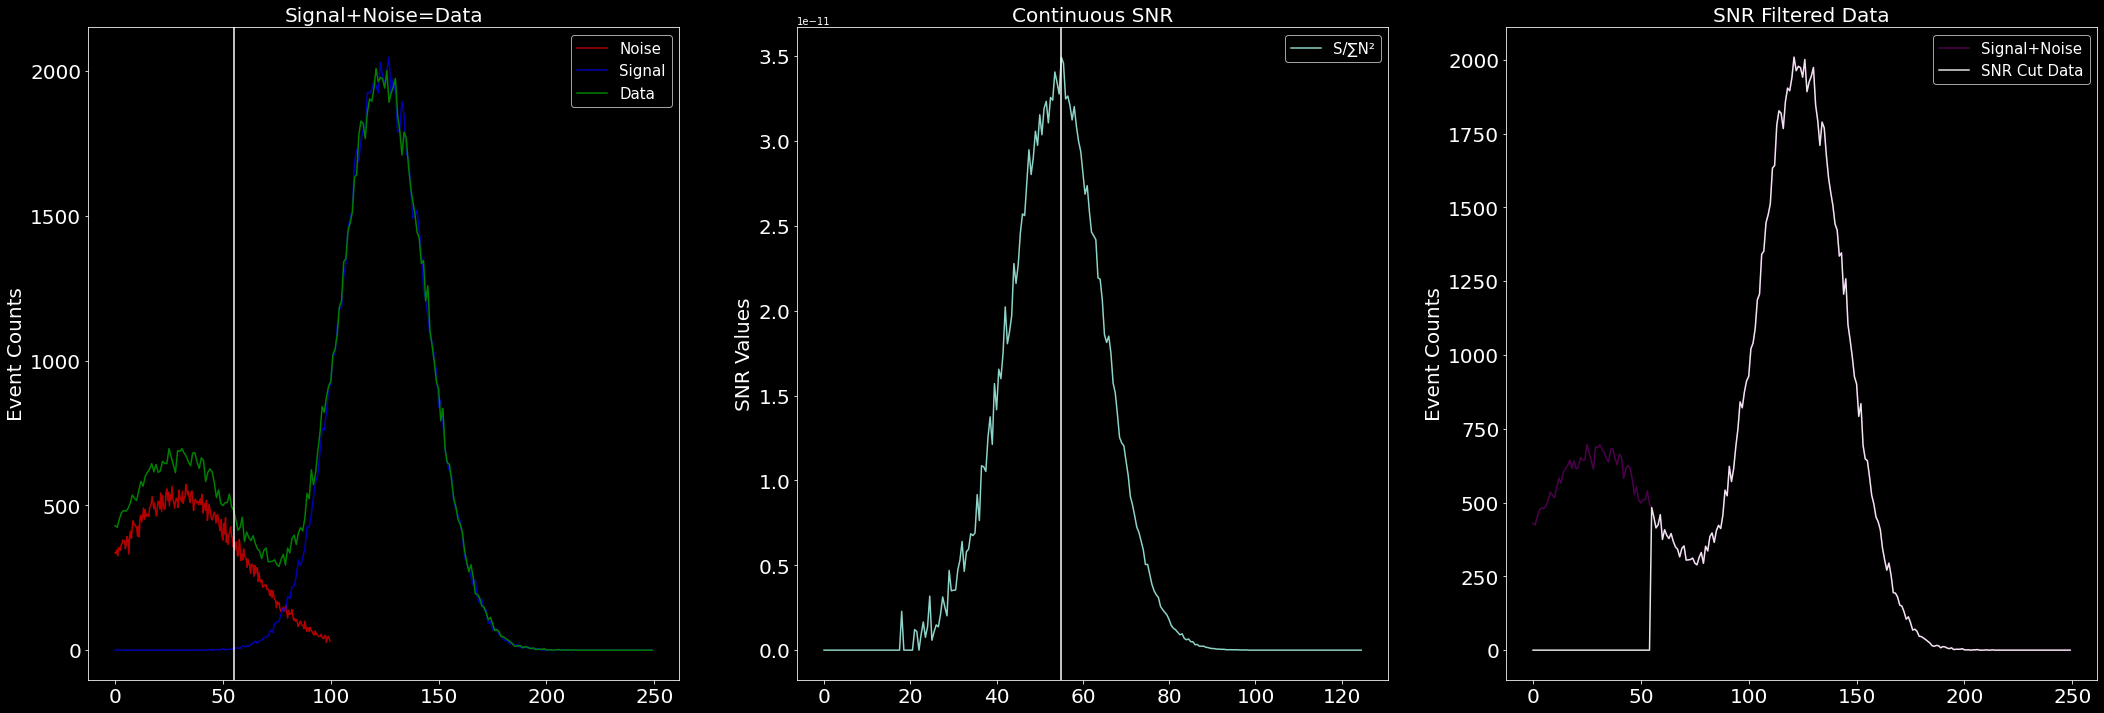

In [6]:
fig, axs = plt.subplots(1,3, figsize=(36,12))
axs[0].plot(nos[1][:-1],nos[0], color="red", alpha=0.7, label='Noise')
axs[0].plot(sig[1][:-1],sig[0], color="blue", alpha=0.7, label='Signal')
axs[0].plot(data_hist[1][:-1],data_hist[0], color="green", label='Data')
axs[0].tick_params(labelsize=20)
axs[0].legend(prop={'size': 15})
axs[0].set_ylabel("Event Counts", size=20)
axs[0].axvline(optimal_cut)
axs[0].set_title("Signal+Noise=Data", size=20)

axs[1].plot(snr_domain, snr_dat, label="S/∑N²")
axs[1].tick_params(labelsize=20)
axs[1].axvline(optimal_cut)
axs[1].legend(prop={'size': 15})
axs[1].set_ylabel("SNR Values", size=20)
axs[1].set_title("Continuous SNR", size=20)

axs[2].plot(data_hist[1][:-1],data_hist[0], color="purple", alpha=0.6, label='Signal+Noise')
axs[2].plot(cut_data_hist[1][:-1], cut_data_hist[0], color="white", alpha=0.9, label="SNR Cut Data") 
axs[2].tick_params(labelsize=20)
axs[2].legend(prop={'size': 15})
axs[2].set_ylabel("Event Counts", size=20)
axs[2].set_title("SNR Filtered Data", size=20);

#### General Approach: To find the best data distribution fit, first the data has to be filtered of it's background signal noise (eliminating all but the desired peak), then the distributions best fit parameters $\mu$ and $\sigma$ can be found iteratively(Gradient Descent).

### Using JAX to perform Gradient Descent to find the optimal Gaussian parameters for our filtered particle dataset.

### The goal is to take the m data points from our particle dataset, $(x_1,y_1),(x_2,y_2),...(x_m,y_m)$, where x would correspond to a bin of some width and y would correspond to the number of counts in that particular bin. We would like to fit this to a gaussian distribution with a function <center> $y=f(x,\hat\beta)=f(x,\beta_1=\sigma,\beta_2=\mu)=\frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{(x-\mu)^2}{\sigma^2}}$. </center>

### We want to find the vector $\hat\beta$ that best fits the particle dataset, in other words, the vector $\hat\beta$ that minmizes the sum of squares $S=\sum_{i=1}^{m}r_{i}^{2}$ or $S(\hat\beta)=\sum_{i=1}^{m}(y_i-f(x_i,\hat\beta))^2$. 

### This occurs when the value of the gradient is zero, since there are two parameters there are two gradient equations: 
### <center>$\dfrac{\partial S}{\partial \beta_j}=2\sum_{i}r_{i}\frac{\partial r_i}{\partial\beta_j}=0, (j=[1,2],{\beta}_j=[\sigma,\mu])$;</center>

### <center> $\dfrac{\partial S}{\partial \beta_1}=2\sum_{i}r_{i}\dfrac{-e^{-\frac{(x-\mu )^2}{\sigma ^2}} \left(2 \mu ^2-\sigma ^2+2 x^2-4 \mu  x\right)}{\sqrt{2 \pi } \sigma ^4}$,</center> <center>$\dfrac{\partial S}{\partial \beta_2}=2\sum_{i}r_{i}\dfrac{-\sqrt{\frac{2}{\pi }} (x-\mu ) e^{-\frac{(x-\mu )^2}{\sigma ^2}}}{\sigma ^3}$.</center>

### The goal now is to implement gradient descent on the cost function, $S(\hat\beta)$, to get $\hat\beta$.
### To accomplosh this, an intial guess $\hat\beta_{0}$ is needed, this would consist of a guess for the $\sigma$ and $\mu$ parameters of the model gaussian, a reasonable guess for $\mu$ would be the appararent maximum in the data set (the peak), and I'm currently unsure of the best way to choose an intiial $\sigma$.

### Goal: We want to apply Gradient Descent to this Non-Linear System so we can obtain the optimal paramets, $\sigma$, and $\mu$ for our particle-dataset.
### Let our cost function be denoted as $\Omega(x)$. The formula to apply is as follows:
### <center>$\bf{a}_{n+1}=\bf{a}_n-\gamma\nabla \Omega(\bf{a}_n)$,</center>
### where $\bf{a}_{n=0}$ is our guess $\hat\beta_{guess}$, and $\gamma$ is the step size, $\gamma \in \mathbb {R} _{+}$; our choice of $\gamma$ should be small enough so that $\Omega(\bf{a}_n)\geq\Omega(\bf{a}_{n+1})$, the idea being the iterative formula should minimize the Cost function until the local minimum is found.
### The sequence of iterations are intended to "descend" the surface of the muiltivariable Cost function in descrete steps until a minimum (likely the global minima) is found and the coordinates for this minimum will be denoted as $\beta_{bf}$; to reiterate, the coordinates indicate the best fit values for the STD and median for the dataset (pun intended). 
#### The nomenclature will be X is the bin number dataset and Y is the event count in the respective bin.

In [7]:
b1 = jnp.linspace(10,50,40) #The first component of Beta corresponds to Signa (STD)
b2 = jnp.linspace(75,175,40) #The second component of Beta corresponds to Mu (Avg.)

#Generic Gaussian Function Above for Examining a specific Beta
def gauss(x,s,m): return (1.0/(s*jnp.sqrt(2.0*math.pi)))*jnp.exp(-(1/2)*((x-m)/s)**2)

def Omega(x,y,s,m): #General Omega/Cost Function.
    n = np.sum(y)
    r = y/n - jnp.exp(-(1/2)*((x-m)/s)**2)/(s*jnp.sqrt(2*jnp.pi))
    return jnp.sum((r**2))

gradient = jit(grad(Omega, argnums=[2,3])) #Gradient of the above Cost function
x, y = cut_data_hist[1][:-1], cut_data_hist[0] #In the future the gradient descent will fit the data including the SNR cut portion.
Y = jnp.asarray(y) #Event Counts in a specific Bin
X = jnp.asarray(x) #Bin Value

def rdata(X, Y, b1, b2): #Computes the Cost Function data
    r_array = []
    for i in range(len(b1)):
        r_row = []
        for j in range(len(b2)):
            r = Omega(X, Y, b1[i], b2[j]).item()
            r_row.append(r)
        r_array.append(r_row)
    return r_array

def gdata(X, Y, b1, b2): #Computes the two gradient components (two Beta components) of the Omega function.
    g1_array, g2_array, g_array = [], [], []
    for i in range(len(b1)):
        g1_row, g2_row, g_row = [], [], []
        for j in range(len(b2)):
            g1, g2 = gradient(X, Y, b1[i], b2[j])[0].tolist(), gradient(X, Y, b1[i], b2[j])[1].tolist()
            g1_row.append(g1)
            g2_row.append(g2)
            g_row.append(np.median([g1,g2]))
        g1_array.append(g1_row)
        g2_array.append(g2_row)
        g_array.append(g_row)
    return g1_array, g2_array, g_array

g1data, g2data, gdata = gdata(X, Y, b1, b2)
rdata = np.asarray(rdata(X, Y, b1, b2))
h,l= np.asarray(jnp.arange(10,50,1)),np.asarray(jnp.arange(75,175,2.5))
g1,g2,g = np.asarray(g1data), np.asarray(g2data), np.asarray(gdata) 
#jnp.asarray doesn't work the same as np.asarray, difference being the output type is Device Array and for the other it's Array.
logg = jnp.log(g)
logg = jnp.nan_to_num(logg, nan=0, posinf=0, neginf=0)

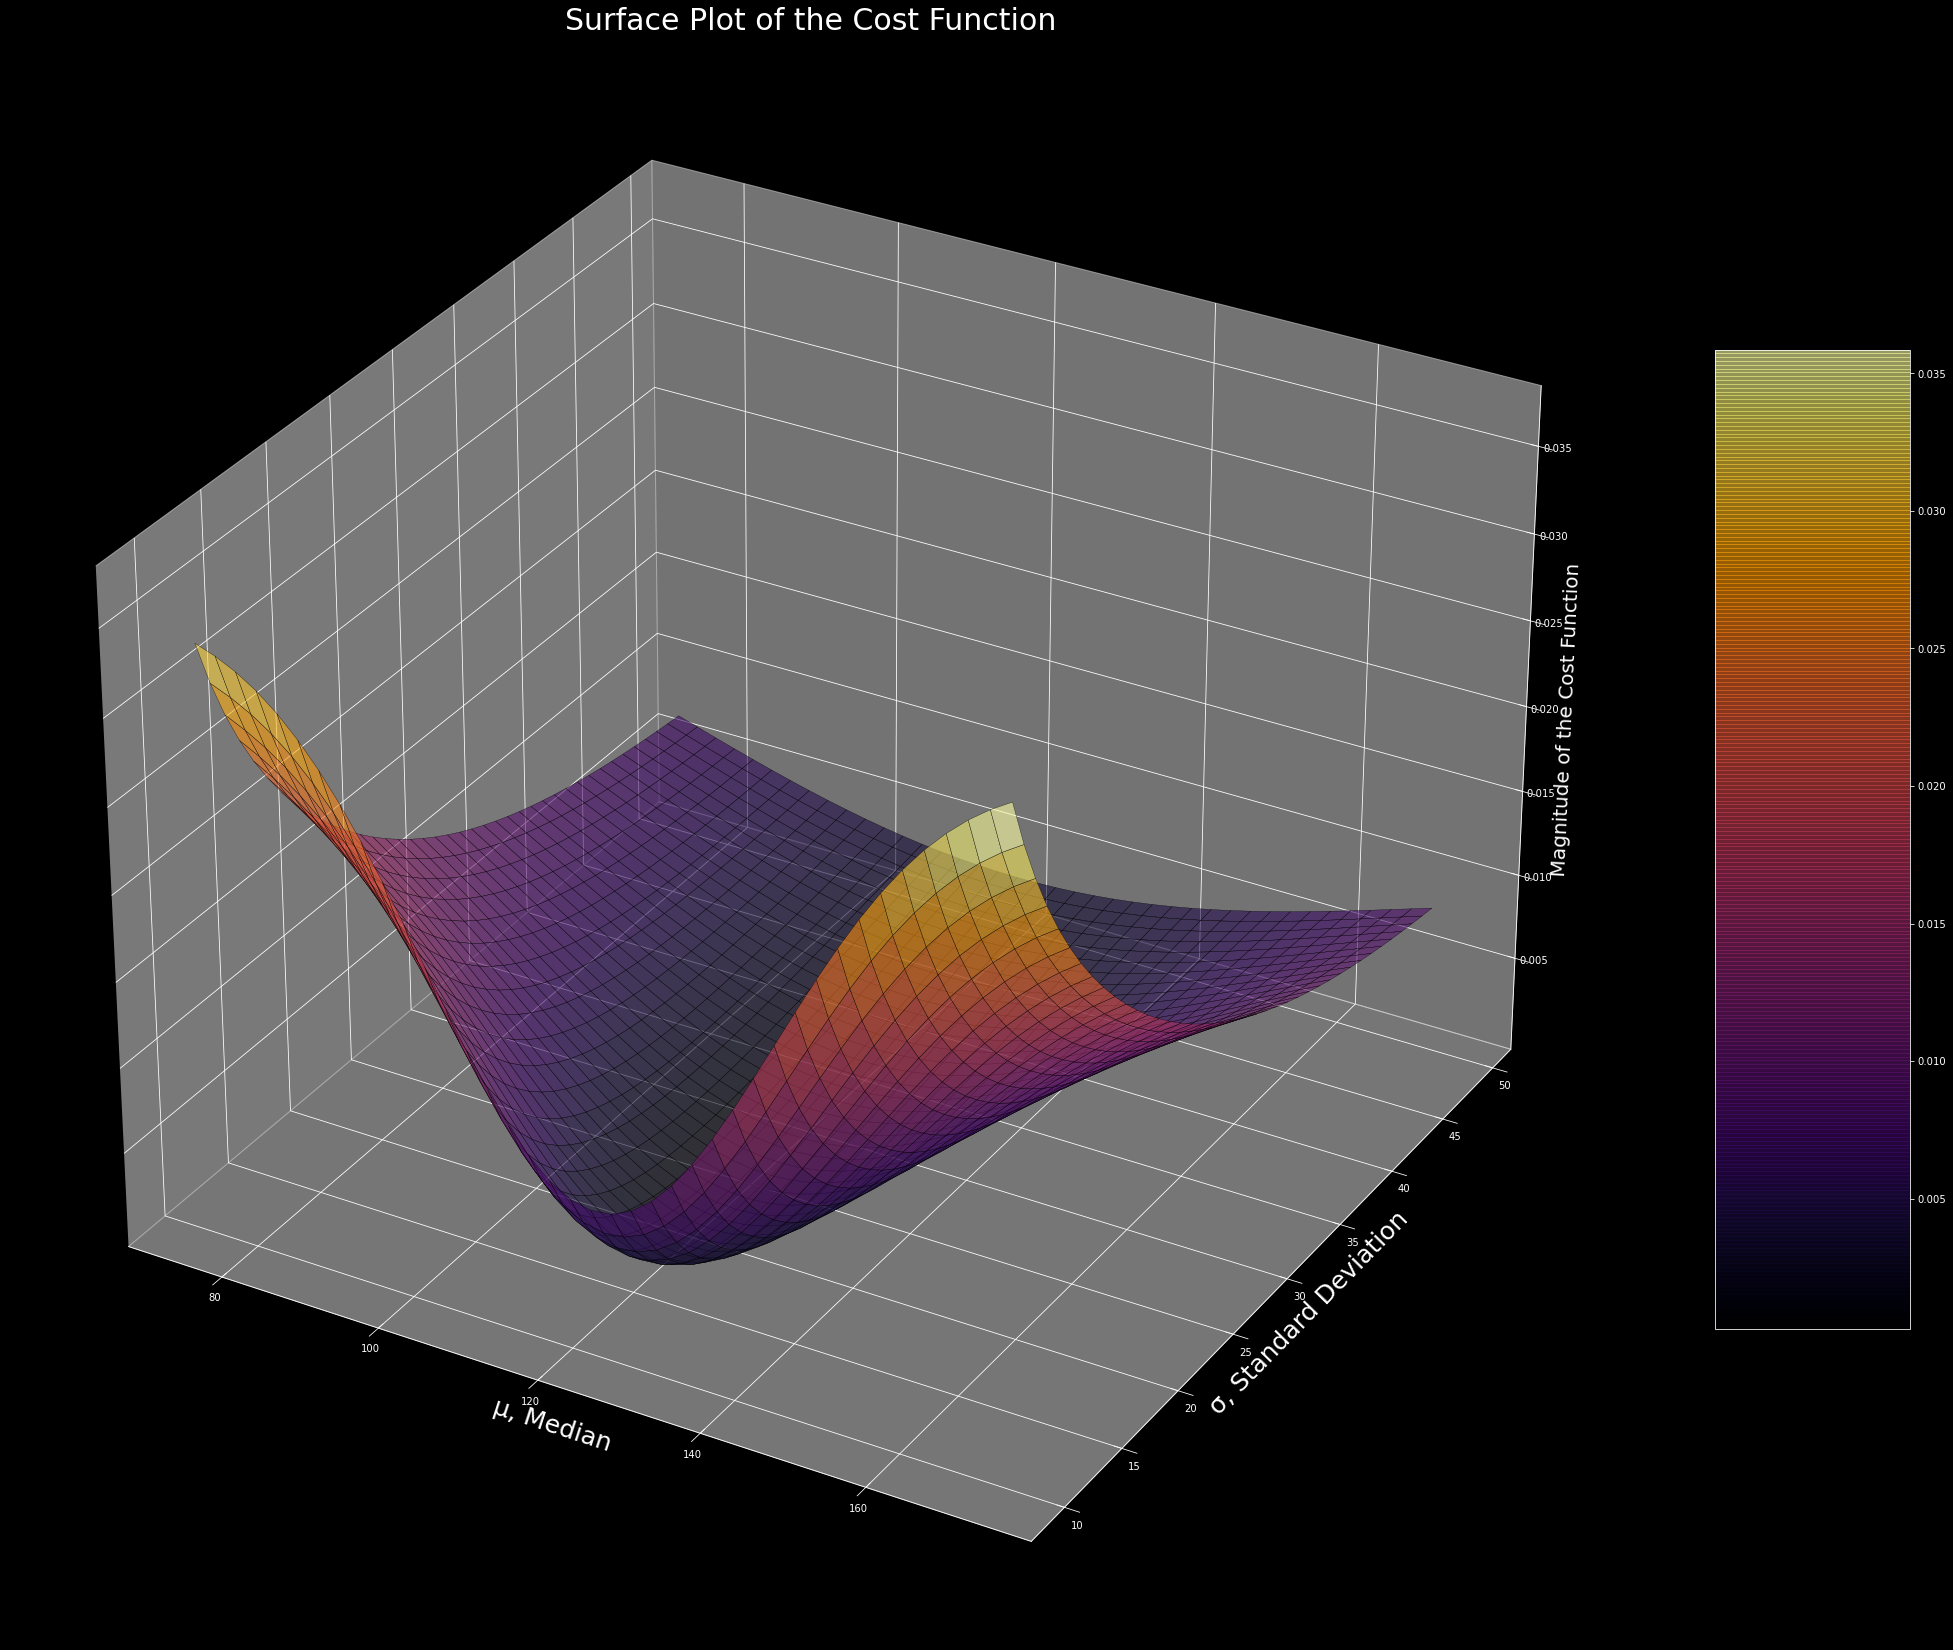

In [8]:
fig = plt.figure(figsize=(36,36))
ax = fig.add_subplot(projection='3d')
ax.set_title("Surface Plot of the Cost Function", size=30)
ax.set_ylabel("σ, Standard Deviation", size=25)
ax.set_xlabel("μ, Median", size=25)
ax.set_zlabel("Magnitude of the Cost Function", size=20)
#ax.invert_yaxis()
h,l= np.asarray(jnp.arange(10,50,1)),np.asarray(jnp.arange(75,175,2.5))
h,l=np.meshgrid(l,h)
plot = ax.plot_surface(h, l, rdata, rstride=1, cstride=1, edgecolors='k', lw=0.3, cmap="inferno", alpha=0.6) #MAGNITUDE OF THE COST/ERROR FUNCTION
plot
fig.colorbar(plot, shrink=0.5, aspect=5);
#ax.plot_surface(l, h, g1, color="blue", alpha=0.2)
#ax.plot_surface(l, h, g2, color="yellow", alpha=0.2)

### It's important to note that there's some issue with the above Cost Function values, from here on the nb certainly contains errors. An updated version of this notebook will follow soon.

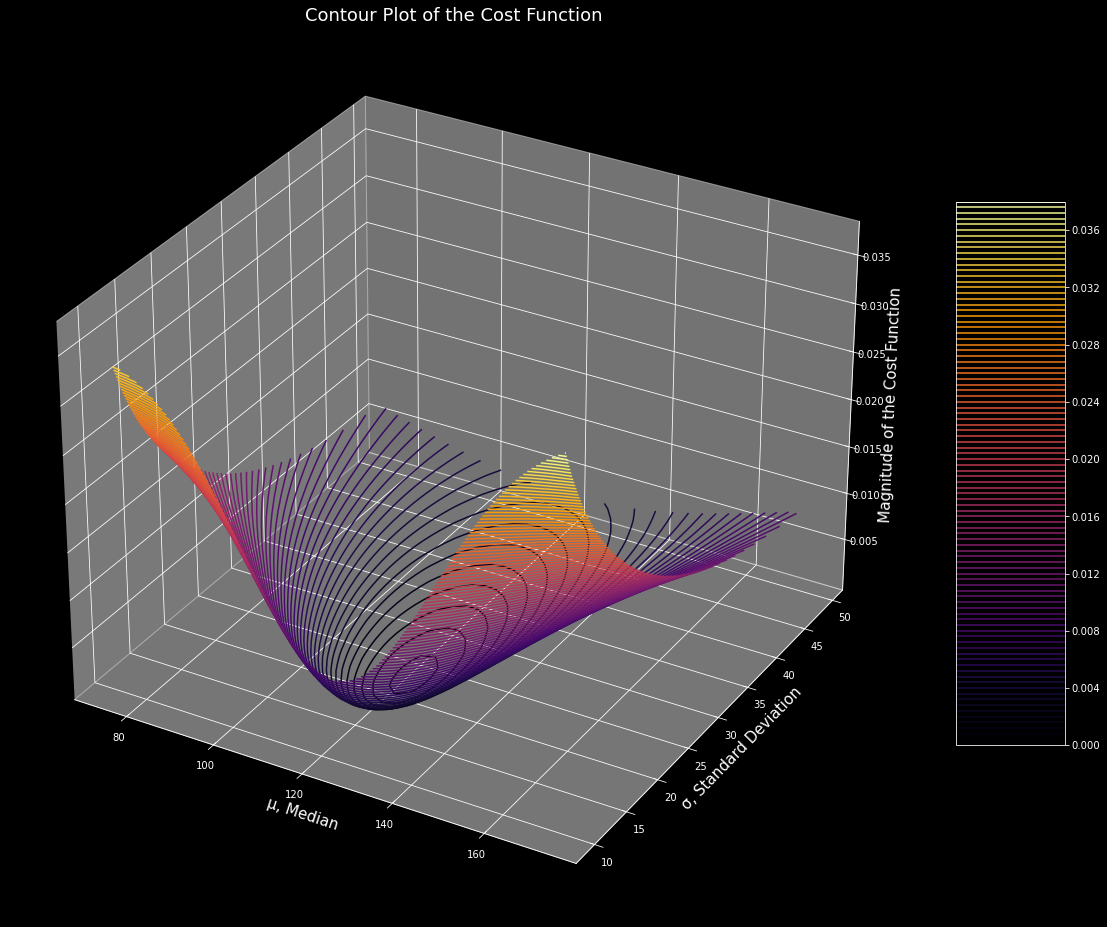

In [9]:
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(projection='3d')
ax.set_title("Contour Plot of the Cost Function", size=18)
ax.set_ylabel("σ, Standard Deviation", size=25)
ax.set_xlabel("μ, Median", size=25)
ax.set_zlabel("Magnitude of the Cost Function", size=15)
#ax.invert_yaxis()
plot = ax.contour(h, l, rdata, 100, cmap="inferno")
plot
fig.colorbar(plot, shrink=0.5, aspect=5); #MAGNITUDE OF GRADIENT OF COST/ERROR FUNCTION

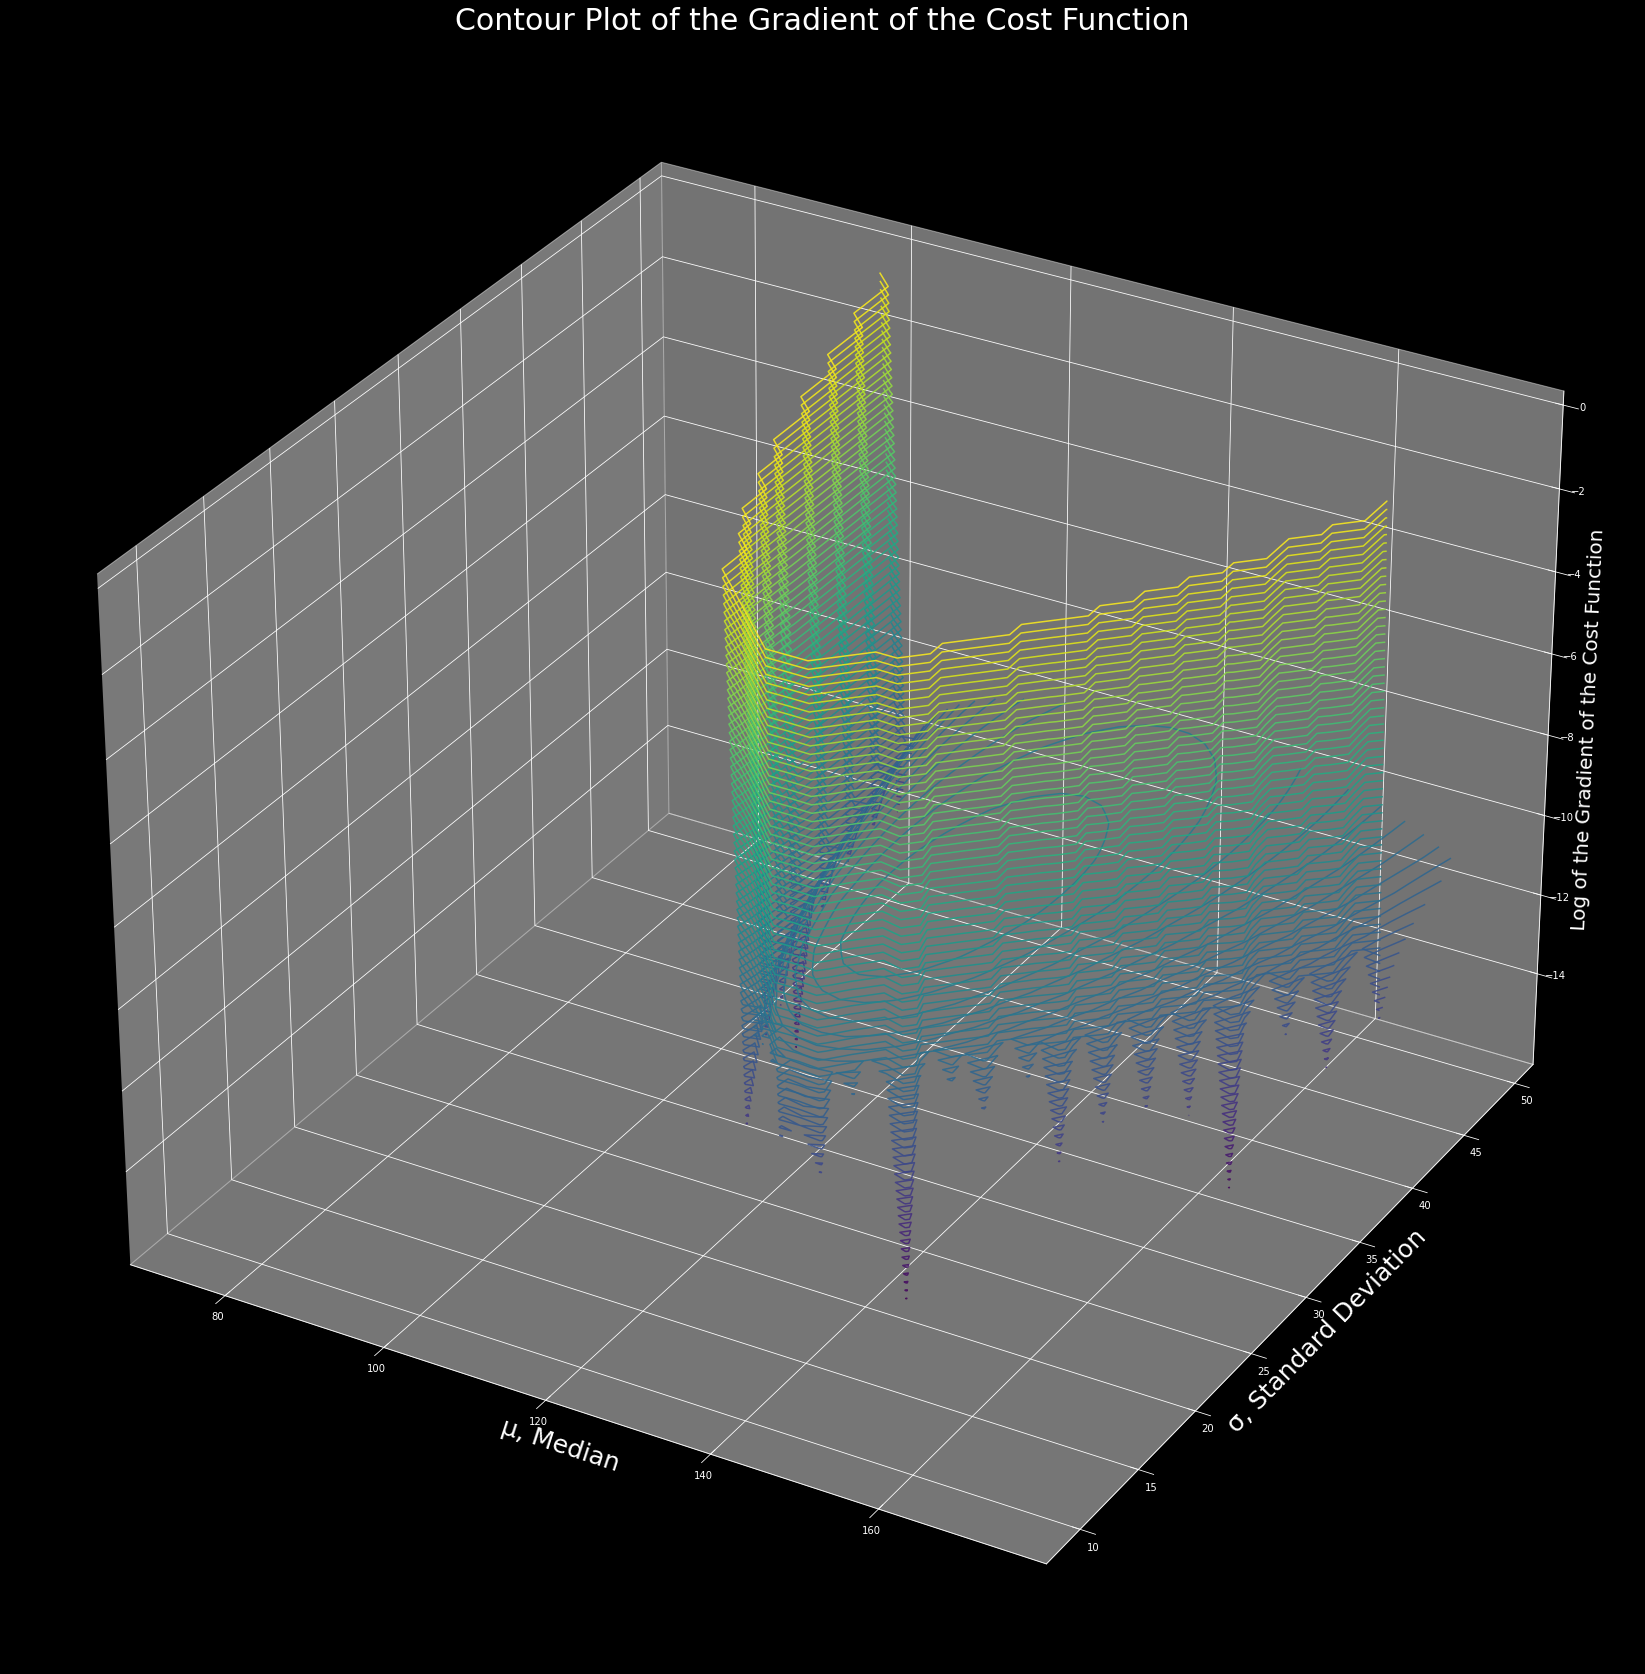

In [10]:
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(projection='3d')
ax.set_title("Contour Plot of the Gradient of the Cost Function", size=30)
ax.set_ylabel("σ, Standard Deviation", size=25)
ax.set_xlabel("μ, Median", size=25)
ax.set_zlabel("Log of the Gradient of the Cost Function", size=20)
#ax.invert_yaxis()
ax.contour(h, l, logg, 100, cmap="viridis", alpha=.9); #MAGNITUDE OF GRADIENT OF COST/ERROR FUNCTION

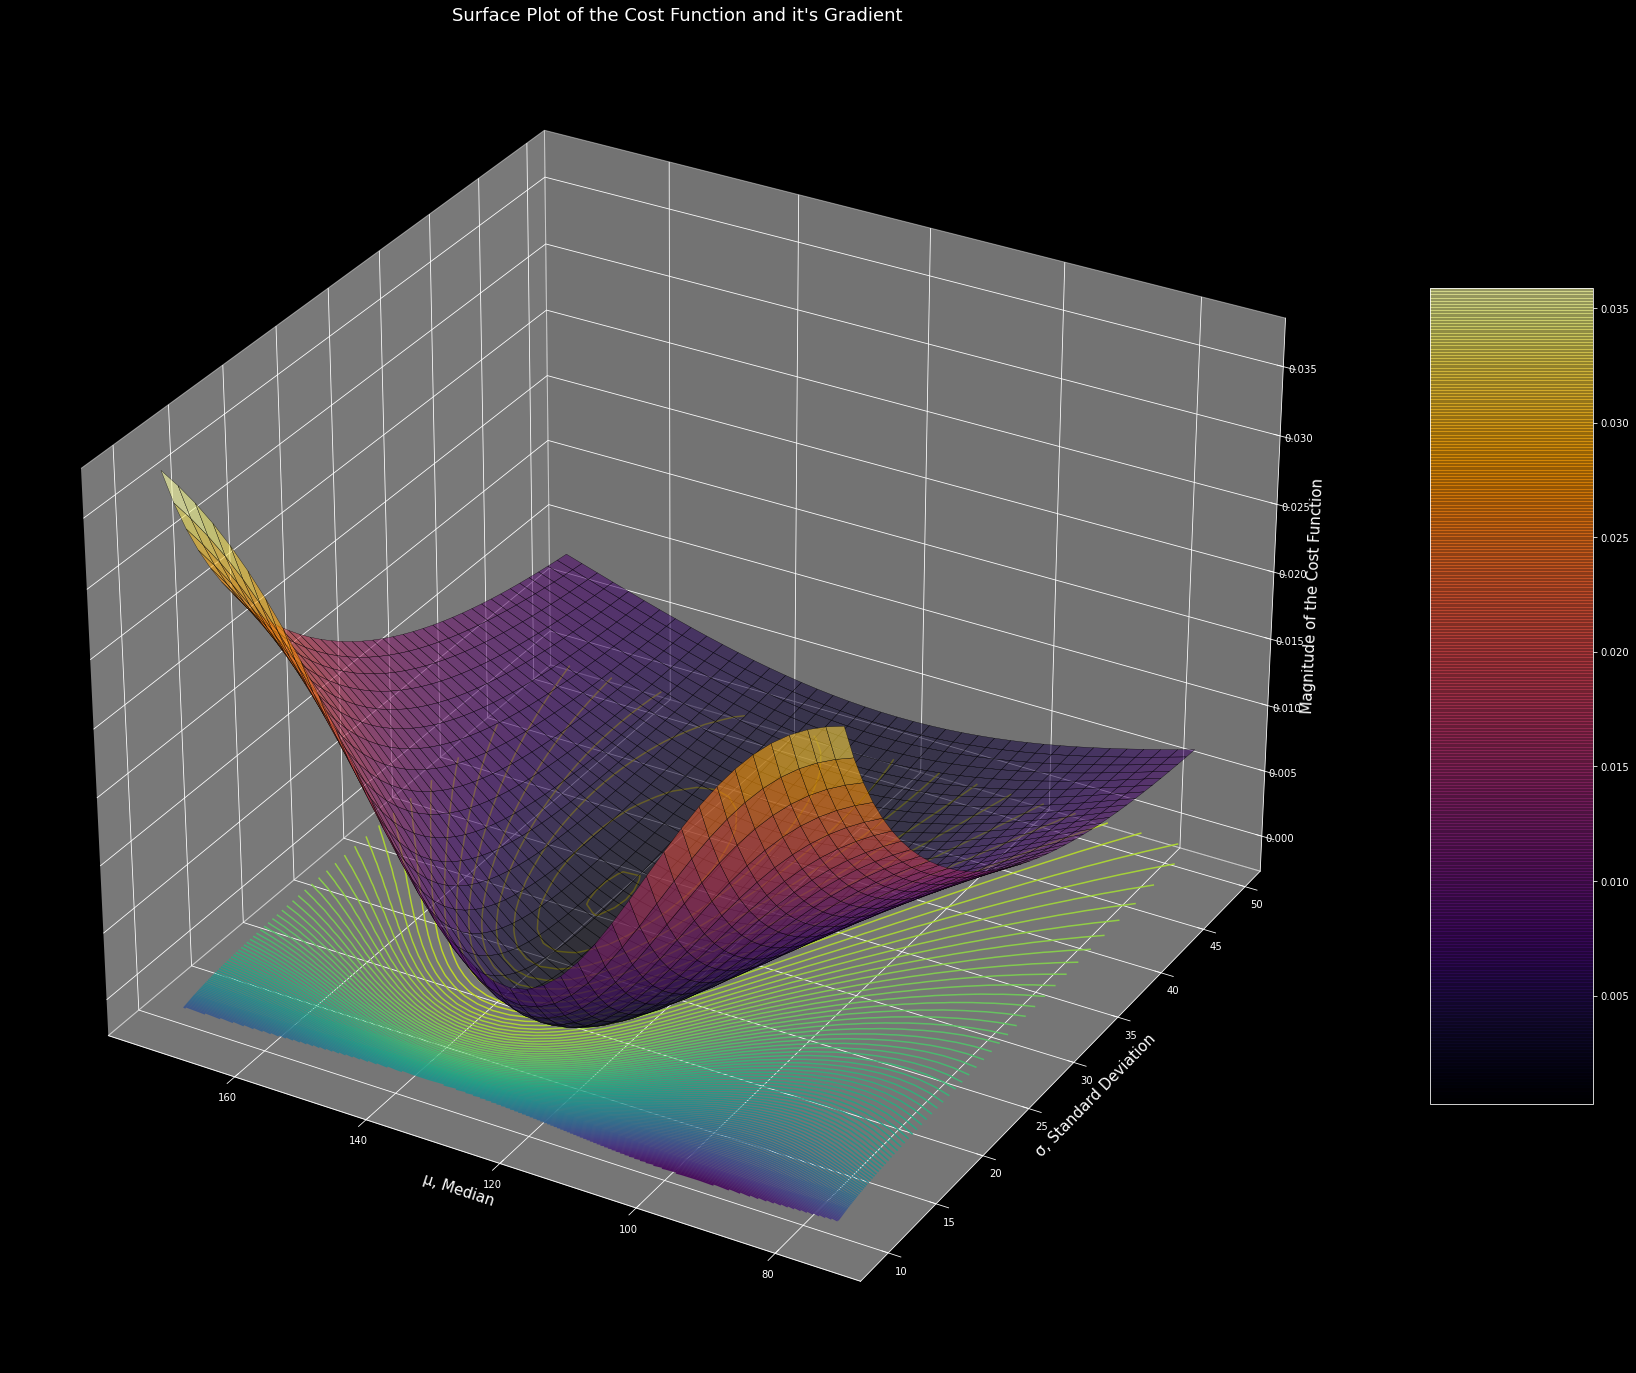

In [11]:
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(projection='3d')
ax.set_title("Contour Plot of the Gradient of the Cost Function", size=30)
ax.set_ylabel("σ, Standard Deviation", size=25)
ax.set_xlabel("μ, Median", size=25)
ax.set_zlabel("Log of the Cost Function", size=25)
h,l= np.asarray(jnp.arange(10,50,1)),np.asarray(jnp.arange(75,175,2.5))
h,l=np.meshgrid(l,h)
ax.contour(h, l, g, 100, cmap="viridis", alpha=.9); #MAGNITUDE OF GRADIENT OF COST/ERROR FUNCTION

ax.set_title("Surface Plot of the Cost Function and it's Gradient", size=18)
ax.set_ylabel("σ, Standard Deviation", size=15)
ax.set_xlabel("μ, Median", size=15)
ax.set_zlabel("Magnitude of the Cost Function", size=15)
ax.invert_yaxis()
plot = ax.plot_surface(h, l, rdata, rstride=1, cstride=1, edgecolors='k', lw=0.3, cmap="inferno", alpha=0.6) #MAGNITUDE OF THE COST/ERROR FUNCTION
plot
fig.colorbar(plot, shrink=0.5, aspect=5);
#ax.plot_surface(l, h, g1, color="blue", alpha=0.2)
#ax.plot_surface(l, h, g2, color="yellow", alpha=0.2)

In [12]:
h,l= np.asarray(jnp.arange(10,50,1)),np.asarray(jnp.arange(75,175,2.5))
minimum = np.min(rdata)
bestfit = np.where(rdata==minimum)
bestfit = h[bestfit[0][0]], l[bestfit[1][0]]
print("If we blatantly search for the global minima over the parameter space for beta, we see that the best fit for the STD is {}, and the best fit for the median is {} GeV.".format(bestfit[0],bestfit[1]))

If we blatantly search for the global minima over the parameter space for beta, we see that the best fit for the STD is 22, and the best fit for the median is 122.5 GeV.


In [13]:
def gradO(X, Y, b1, b2): #Computes the gradient magnitude of the Omega function.
    g1, g2 = gradient(X, Y, b1, b2)[0].tolist(), gradient(X, Y, b1, b2)[1].tolist()
    return np.asarray([g1, g2])
    #return np.median([g1,g2])

def grad_descent(X, Y, s, m, step_size, iterations):
    """
    X : The dataset full of the bin Energy values
    Y : The dataset full of the amplitudes corresponding to the specific bins
    s : The intial guess for the STD of the function representing the dataset
    m : The intial guess for the median value of the function representing the dataset
        The step_size is self explanatory
    """
    beta = np.asarray([s, m])
    n = len(Y) #Normalizes the Function.
    beta_history, cost_history = [], []
    for i in range(iterations):
        delO = gradO(X,Y,beta[0],beta[1])
        beta = beta - (1/n) * step_size * delO
        cost = jnp.sum(Y-jnp.exp(-((X-beta[1])/beta[0])**2)/(beta[0]*jnp.sqrt(2*jnp.pi)))
        beta_history.append(beta)
        cost_history.append(cost.item())
        if beta[0] < 10: #Exception for when the algorithim considers STDs outside of the predetermined bounds.
            print("Iteration {}: The algorithm has encountered an out of range error... ending algorthim now.".format(i)) 
            break
    return beta, beta_history[:-1], cost_history[:-1]

In [14]:
guess_beta, step_size, iterations = [20, 125], 0.5, 100
final_beta, beta_history, cost_history = grad_descent(X,Y,15.0,125.0,step_size,iterations)
cost_data = []
def cdata(X, Y, b1, b2): #Computes the Cost Function data
    c = Omega(X, Y, b1, b2).item()
    return c
for beta in beta_history:
    b0, b1 =  beta[0], beta[1]
    cost_data.append(cdata(X, Y, b0, b1))

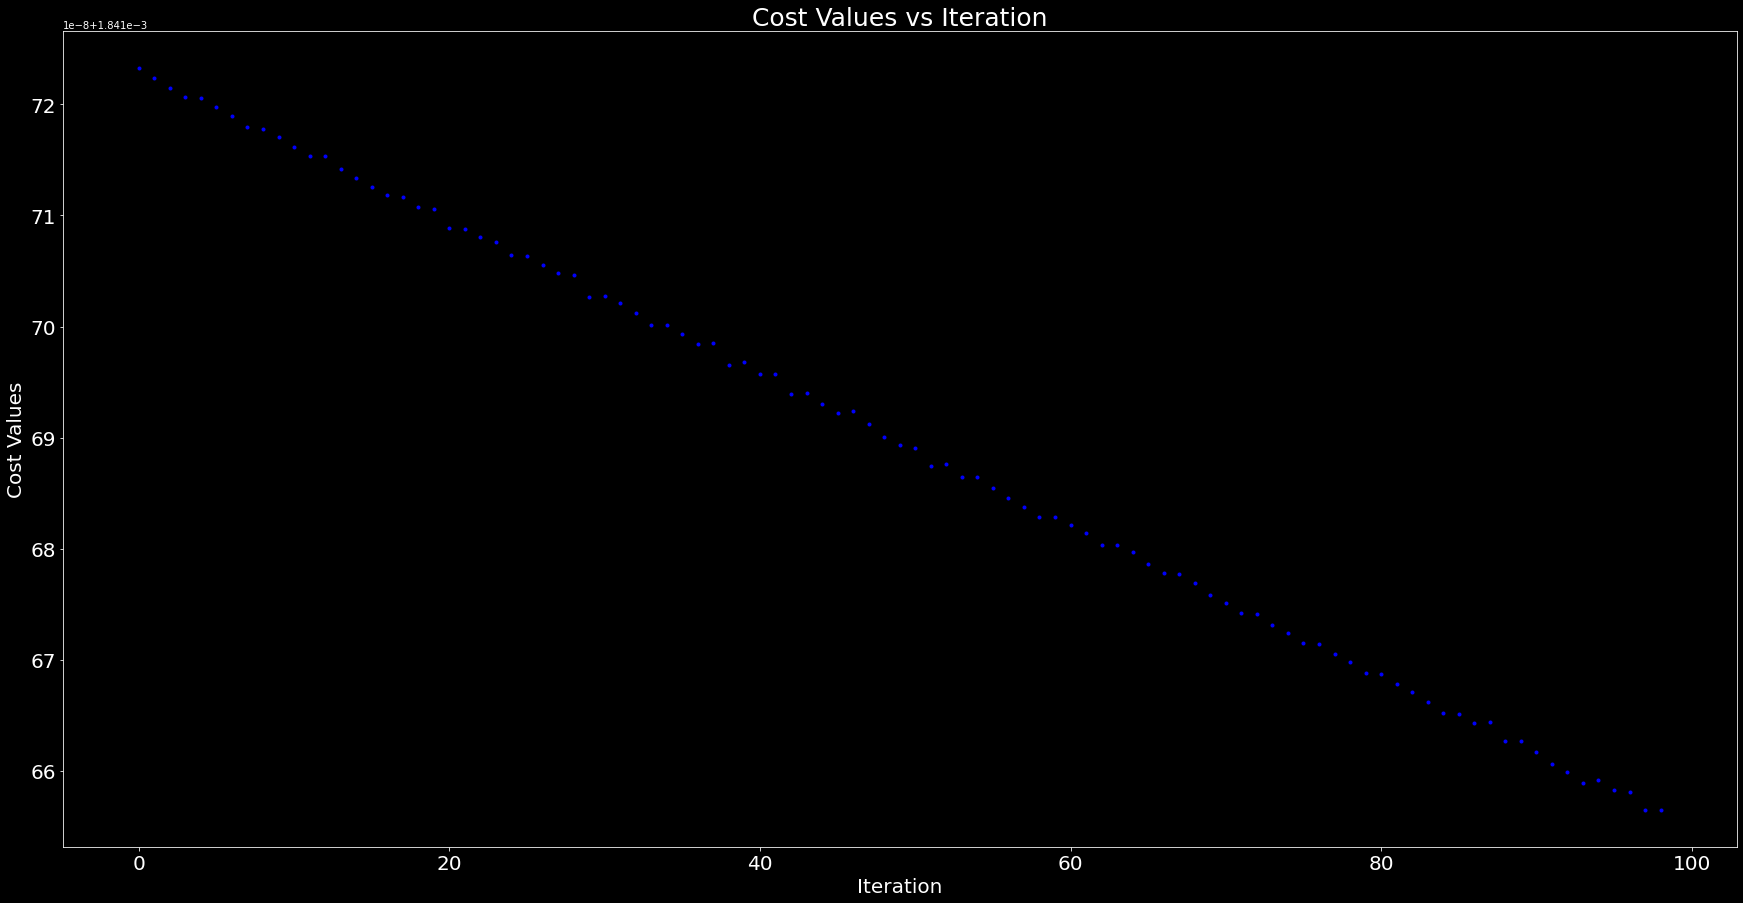

In [15]:
fig,ax = plt.subplots(figsize=(30,15))
logg = jnp.log(cost_data - np.min(cost_data))
ch = jnp.nan_to_num(logg, nan=0, posinf=0, neginf=0)
ax.set_ylabel('Cost Values', size=20)
ax.set_xlabel('Iteration', size=20)
ax.set_title("Cost Values vs Iteration", size=25)
ax.tick_params(labelsize=20)
_=ax.plot(range(len(cost_data)),cost_data,'b.')

In [16]:
print("The algorithim has found the best fit values for the STD and median to be, {} and {} respectively.".format(round(final_beta[0],3),round(final_beta[1],3)))

The algorithim has found the best fit values for the STD and median to be, 15.0 and 125.0 respectively.


''

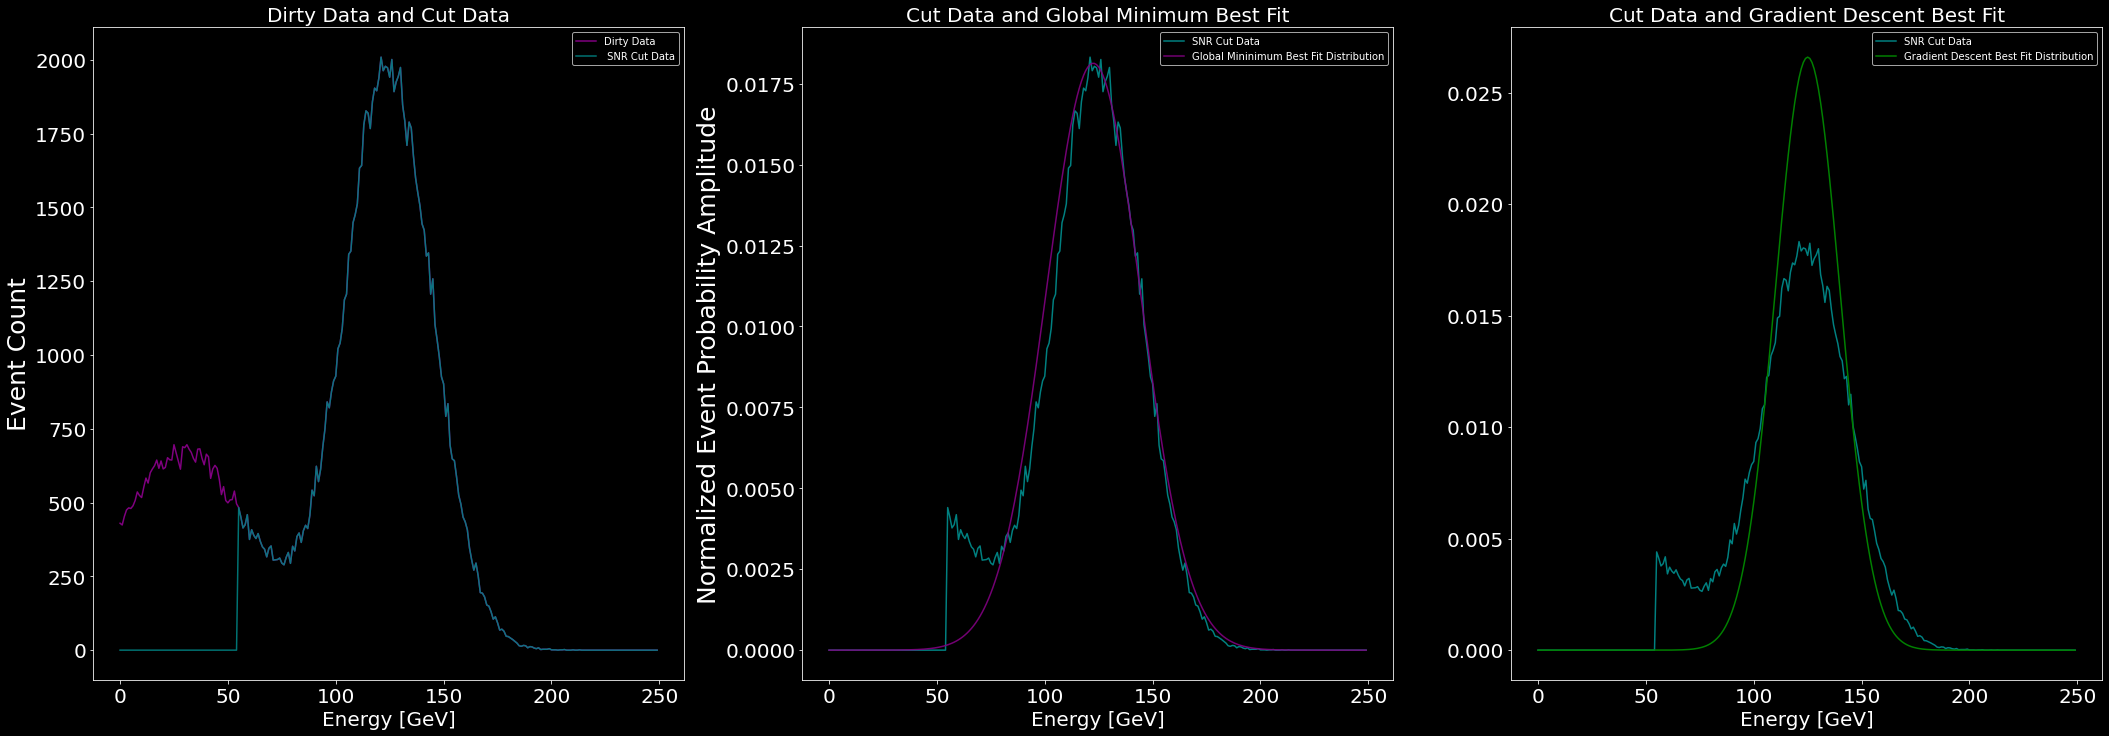

In [17]:
fig, axs = plt.subplots(1,3, figsize=(36,12))
axs[0].plot(data_hist[1][:-1],data_hist[0], color="purple", label='Dirty Data')
axs[0].plot(cut_data_hist[1][:-1], cut_data_hist[0], color="teal", alpha=0.9, label=" SNR Cut Data") 
#I scale the amplitudes here for analyzing purposes only...
axs[0].tick_params(labelsize=20)
axs[0].set_xlabel("Energy [GeV]", size=20)
axs[0].set_ylabel("Event Count", size=25)
axs[0].legend()
axs[0].set_title("Dirty Data and Cut Data", size=20)
axs[1].plot(cut_data_histn[1][:-1], cut_data_histn[0], color="teal", label="SNR Cut Data")
axs[1].plot(cut_data_hist[1][:-1], gauss(cut_data_hist[1][:-1],bestfit[0],bestfit[1]), color="purple", alpha=0.9, label="Global Mininimum Best Fit Distribution")
axs[1].tick_params(labelsize=20)
axs[1].set_xlabel("Energy [GeV]", size=20)
axs[1].set_ylabel("Normalized Event Probability Amplitude", size=25) #Normalized meaning the sum of probabilties is unity.
axs[1].legend()
axs[1].set_title("Cut Data and Global Minimum Best Fit", size=20)
axs[2].plot(cut_data_histn[1][:-1], cut_data_histn[0], color="teal", label="SNR Cut Data")
axs[2].plot(cut_data_hist[1][:-1], gauss(cut_data_hist[1][:-1],final_beta[0],final_beta[1]), color="green", label="Gradient Descent Best Fit Distribution")
axs[2].tick_params(labelsize=20)
axs[2].set_xlabel("Energy [GeV]", size=20)
axs[2].legend()
axs[2].set_title("Cut Data and Gradient Descent Best Fit", size=20)
;